In [350]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("onlyrohit/all-kpop-idols")

#print("Path to dataset files:", path)

Импорт датасета

In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Импорт библиотек

In [352]:
dataset_path = r"C:\Users\vaind\OneDrive\Desktop\ml\datasets\kpop_idol_followers.csv"
df = pd.read_csv(dataset_path, sep=';')
df.head()

,Stage.Name,Group,ig_name,Followers,Gender.x,Full.Name,Korean.Name,K.Stage.Name,Date.of.Birth,Debut,Company,Country,Height,Weight,Gender.y,age,year.career
0,Ace,VAV,ace.vav,335439,Boy,Jang Wooyoung,장우영,에이스,28.08.1992,31.10.2015,A team,South Korea,177.0,63.0,M,30,7
1,Ahra,FAVORITE,ahra.view,12342,Girl,Go Ahra,고아라,아라,21.02.2001,05.07.2017,Astory,South Korea,NaN,NaN,F,22,6
2,Ahyoung,DAL SHABET,a_young91,10479,Girl,Cho Jayoung,조자영,아영,26.05.1991,03.01.2011,Happy Face,South Korea,NaN,NaN,F,32,12
3,Alice,HELLO VENUS,hv_alice,11135,Girl,Song Joohee,송주희,앨리스,21.03.1990,09.05.2012,Fantagio,South Korea,166.0,47.0,F,33,11
4,Amber,F(X),ajol_llama,5519743,Girl,Amber Josephine Liu,엠버 조세핀 리우,엠버,18.09.1992,05.09.2009,SM,USA,167.0,NaN,F,30,13


In [353]:
df.info()
df.describe()
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Stage.Name     406 non-null    object 
 1   Group          406 non-null    object 
 2   ig_name        406 non-null    object 
 3   Followers      406 non-null    int64  
 4   Gender.x       406 non-null    object 
 5   Full.Name      406 non-null    object 
 6   Korean.Name    406 non-null    object 
 7   K.Stage.Name   406 non-null    object 
 8   Date.of.Birth  406 non-null    object 
 9   Debut          406 non-null    object 
 10  Company        406 non-null    object 
 11  Country        406 non-null    object 
 12  Height         248 non-null    float64
 13  Weight         175 non-null    float64
 14  Gender.y       406 non-null    object 
 15  age            406 non-null    int64  
 16  year.career    406 non-null    int64  
dtypes: float64(2), int64(3), object(12)
memory usage: 54.1

Weight           231
Height           158
Stage.Name         0
Group              0
ig_name            0
Full.Name          0
Korean.Name        0
Followers          0
Gender.x           0
Date.of.Birth      0
K.Stage.Name       0
Company            0
Debut              0
Country            0
Gender.y           0
age                0
year.career        0
dtype: int64

Первичный анализ

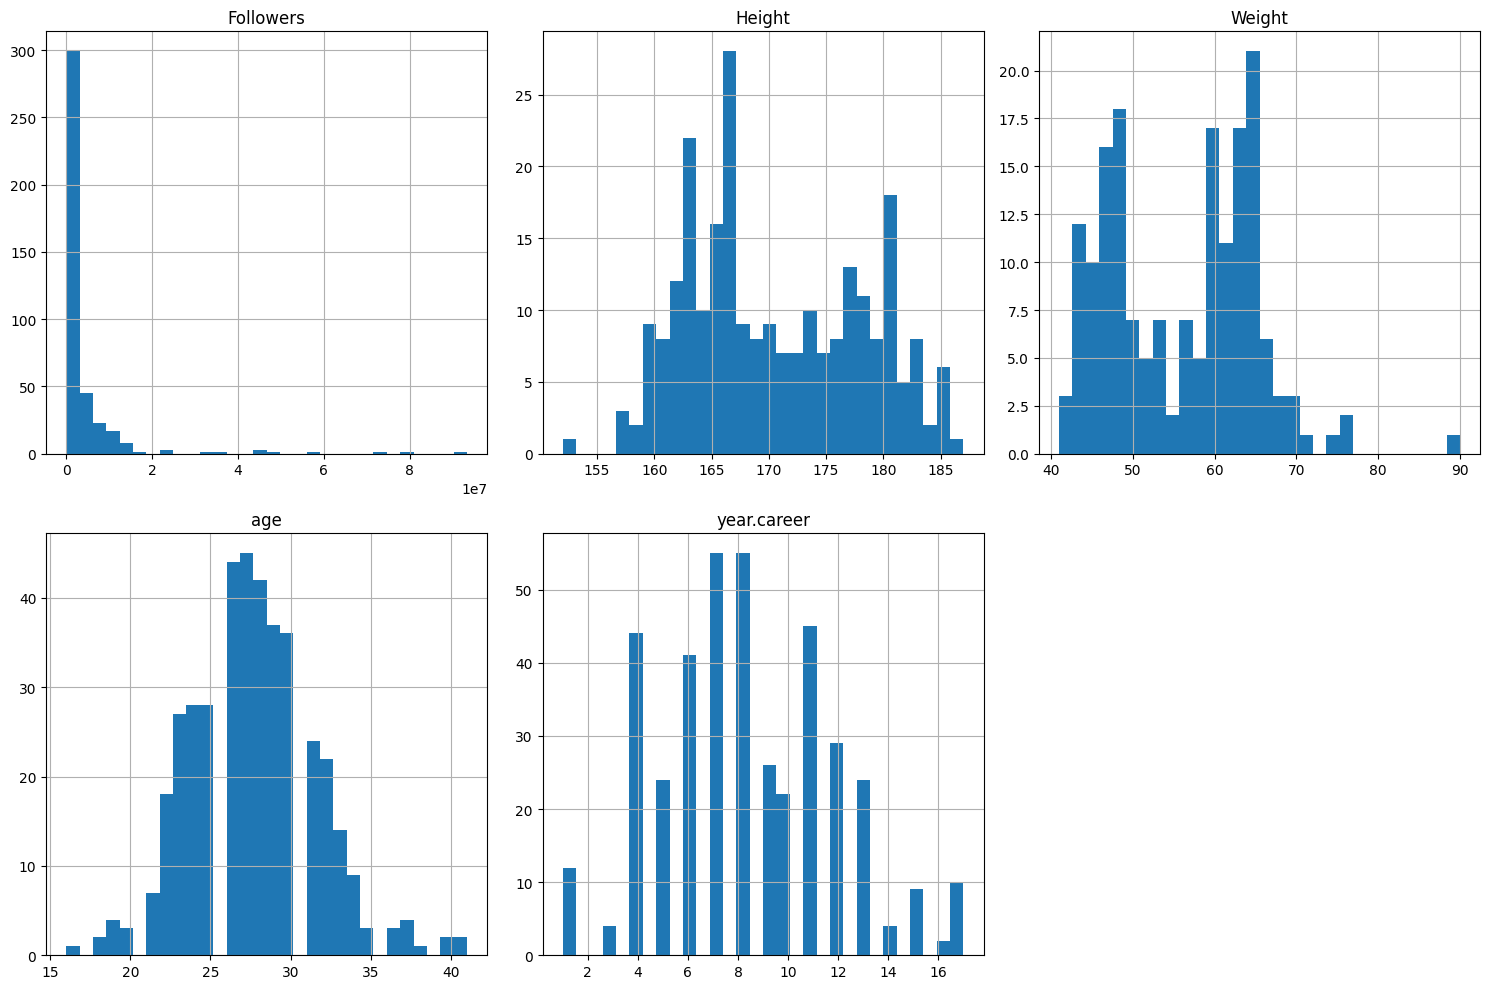

In [354]:
numeric_cols = df.select_dtypes(include='number')

numeric_cols.hist(bins=30, figsize=(15, 10), layout=(len(numeric_cols.columns)//3 + 1, 3))
plt.tight_layout()
plt.show()

Распределение признаков

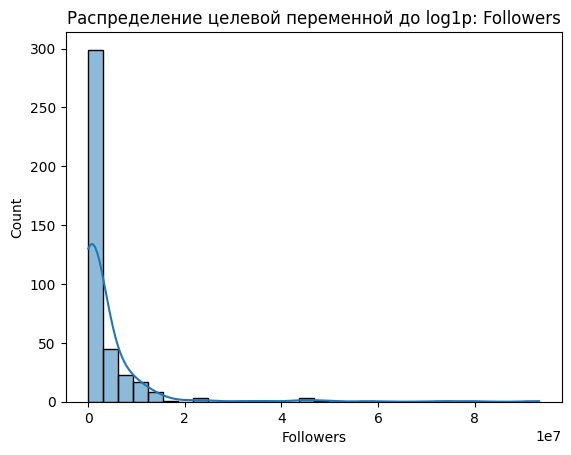

In [371]:
target = "Followers"

sns.histplot(df[target], kde=True, bins=30)
plt.title(f"Распределение целевой переменной до log1p: {target}")
plt.show()

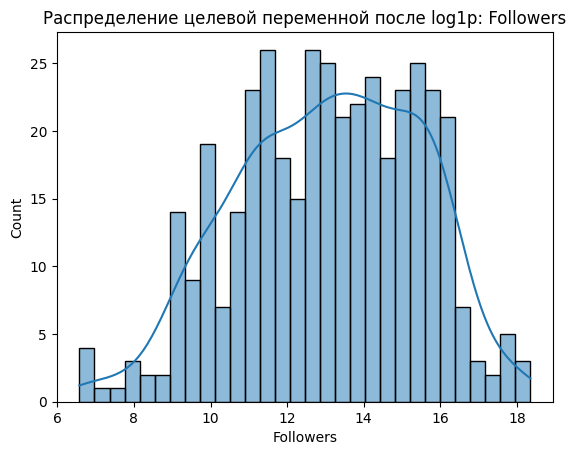

In [356]:
target = "Followers"
y_transformed = np.log1p(df[target])
sns.histplot(y_transformed, kde=True, bins=30)
plt.title(f"Распределение целевой переменной после log1p: {target}")
plt.show()

Распределение целевой переменной до log1p и после

In [357]:
print(f"Weight пропусков: {df['Weight'].isnull().sum()}")
print(f"Height пропусков: {df['Height'].isnull().sum()}")

Weight пропусков: 231
Height пропусков: 158


Пропущенные значения

In [358]:
df['Weight'] = df['Weight'].fillna(df['Weight'].median())
df['Height'] = df['Height'].fillna(df['Height'].median())

Замена пропущенных значений на медиану

In [359]:
print(f"Weight пропусков: {df['Weight'].isnull().sum()}")
print(f"Height пропусков: {df['Height'].isnull().sum()}")

Weight пропусков: 0
Height пропусков: 0


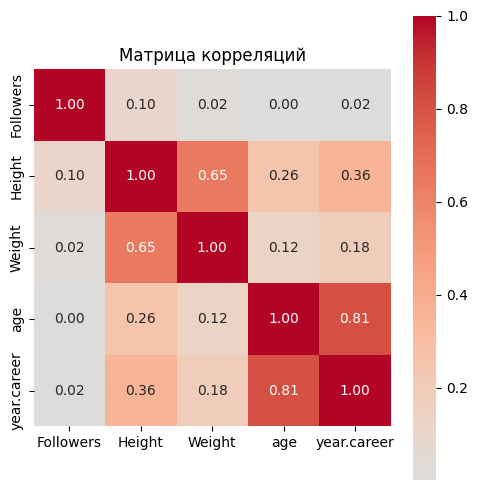

In [360]:
numeric_df = df.select_dtypes(include=[np.number])

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Матрица корреляций')
plt.tight_layout()
plt.show()

In [361]:

vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i)
                   for i in range(numeric_df.shape[1])]

print(vif_data)

       Feature         VIF
0    Followers    1.150949
1       Height  245.697201
2       Weight  142.923902
3          age  134.514724
4  year.career   17.733038


Значения VIF больше 10, присутвует большая мультиколинеарность

In [362]:
X = numeric_df.drop(columns=['Followers'])
y = numeric_df['Followers']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)

print("Линейная регрессия:")
print("R^2:", r2_score(y_test, y_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_lin))

Линейная регрессия:
R^2: -0.18842918386182395
RMSE: 5734495.111334484
MAPE: 134.30281874807645


Линейная регрессия показала крайне низкую точность: модель плохо объясняет данные и предсказывает значения с большой ошибкой, о чём свидетельствует отрицательный R^2 (-0.19), высокий RMSE (5,7 млн) и очень большой MAPE (134%), указывающие на то, что предсказания значительно отклоняются от реальных значений и хуже, чем просто среднее.

In [363]:
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)

y_pred_ridge = ridge_reg.predict(X_test)

print("\nГребневая регрессия (Ridge):")
print("R^2:", r2_score(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_ridge))


Гребневая регрессия (Ridge):
R^2: -0.1883694996895482
RMSE: 5734351.113317588
MAPE: 134.30043841121994


Гребневая регрессия показала крайне низкую точность: модель не объясняет данные и делает предсказания с большой ошибкой, о чём свидетельствуют отрицательный R^2 (-0.188), высокий RMSE (5,73 млн) и очень большой MAPE (134%), что практически повторяет результаты простой линейной регрессии.

In [372]:
X = numeric_df.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)


  Feature  VIF
0     PC1  1.0
1     PC2  1.0
2     PC3  1.0
3     PC4  1.0


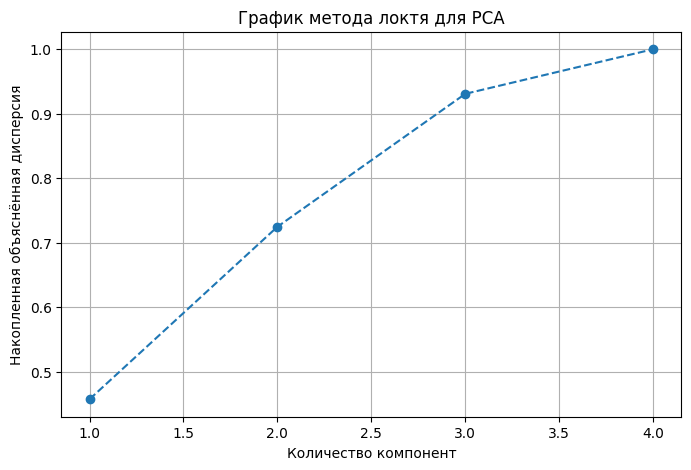

In [370]:
vif_data_after = pd.DataFrame()
vif_data_after["Feature"] = [f"PC{i+1}" for i in range(X_pca.shape[1])]
vif_data_after["VIF"] = [variance_inflation_factor(X_pca, i) for i in range(X_pca.shape[1])]

print(vif_data_after)

explained_variance_ratio = PCA().fit(X_pca).explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная объяснённая дисперсия')
plt.title('График метода локтя для PCA')
plt.grid(True)
plt.show()

После применения PCA все главные компоненты стали ортогональными, что подтверждается VIF = 1 для каждой компоненты - мультиколлинеарность полностью устранена.

In [367]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

lin_reg_pca = LinearRegression()
lin_reg_pca.fit(X_train_pca, y_train_pca)
y_pred_lin_pca = lin_reg_pca.predict(X_test_pca)

print("Линейная регрессия (PCA):")
print("R^2:", r2_score(y_test_pca, y_pred_lin_pca))
print("RMSE:", np.sqrt(mean_squared_error(y_test_pca, y_pred_lin_pca)))
print("MAPE:", mean_absolute_percentage_error(y_test_pca, y_pred_lin_pca))

Линейная регрессия (PCA):
R^2: 0.9999772816055487
RMSE: 25072.48329806412
MAPE: 0.4156609003695098


После применения PCA линейная регрессия показала практически идеальную точность (R^2 = 0.99998, RMSE = 25,072, MAPE = 0.42%), так как мультиколлинеарность была устранена и модель эффективно использует независимые компоненты.

In [368]:
ridge_reg_pca = Ridge(alpha=1.0)
ridge_reg_pca.fit(X_train_pca, y_train_pca)
y_pred_ridge_pca = ridge_reg_pca.predict(X_test_pca)

print("\nГребневая регрессия (Ridge, PCA):")
print("R^2:", r2_score(y_test_pca, y_pred_ridge_pca))
print("RMSE:", np.sqrt(mean_squared_error(y_test_pca, y_pred_ridge_pca)))
print("MAPE:", mean_absolute_percentage_error(y_test_pca, y_pred_ridge_pca))


Гребневая регрессия (Ridge, PCA):
R^2: 0.9999651741511343
RMSE: 31042.692883183685
MAPE: 0.33963908660882


После применения PCA гребневая регрессия показала очень высокую точность (R^2 = 0.99997, RMSE = 31,043, MAPE = 0.34%), так как мультиколлинеарность устранена и модель эффективно использует ортогональные компоненты.